In this notebook, we will create a CMR network, and use it to simulate free recall data, with the aim of recreating effects seen in the **lag-CRP curve** (forward asymmetry, contiguity) and **serial-position curve** (RIFO/RIFA, concreteness, passage structure).

First I will create a network for each participant based on their free recalls. Then, I will use the networks to simulate free recall, taking into account other factors that influence memory.

* In this notebook, we will focus on modeling free recall of list A, passage 1.

# (0) Load in Data

In [1]:
import pandas as pd
from cymr import fit, cmr
import numpy as np
import matplotlib.pyplot as plt 

# (0) Load in data
our_df = pd.read_csv("C:/Summer 2023 - DSI-SRP/featureFR/Recall Analysis/data/psifr_al1_sl.csv")

# (1) Create function to a number to each sentence
def assign_item_number(story_list: str, passage: int, item: int):
    """Assign item number based on story_list, passage, and item of the sentence.

    Args:
        story_list (str): e.g. 'A',
        passage (int): e.g. 1
        item (int): e.g. 0
    """
    item_number = 100*(ord(story_list) - ord('A'))  + 20*(passage - 1) + item
    return item_number

assign_item_number(story_list="B",passage=1,item=1)

# (1.1) Add item numbers to dataframe
story_list_col = our_df.story_list.to_list()
passage_col = our_df.passage.to_list()
item = our_df.item.to_list()

item_numbers = [assign_item_number(story_list_col[i], passage_col[i], item[i]) for i in range(len(our_df))]
our_df["item_index"]  = item_numbers
our_df.head(1)

# (1.2) Create formatted dataframe
cmr_columns = ['subject', 'list', 'position', 'trial_type', 'item', 'item_index']
data_lst = []

for index, row in our_df.iterrows():
    if row["study"]:
        study_item = [
            row["subject"],
            row["list"],
            row["input"],
            "study",
            row["item_string"],
            row["item_index"]
        ]
        data_lst.append(study_item)
    if row["recall"]:
        recall_item = [
            row["subject"],
            row["list"],
            int(row["output"]),
            "recall",
            row["item_string"],
            row["item_index"]
        ]
        data_lst.append(recall_item)
        
our_data = pd.DataFrame(data_lst, 
                           columns = cmr_columns).sort_values(["subject", "list", "trial_type", "position"], 
                                                              ascending=[True, True, False, True],
                                                              ignore_index=True)
print(len(our_data))

# (Optional) Restrict modeling to passage 1
our_data = our_data.query("item_index < 20")
our_data


2226


,subject,list,position,trial_type,item,item_index
0,0,0,1,study,Smaller and larger abscesses may require diffe...,0
1,0,0,2,study,Smaller abscesses are typically less than five...,1
2,0,0,3,study,Applying warm soaks can promote pus straining ...,2
3,0,0,4,study,Larger abscesses will require an incision to s...,3
4,0,0,5,study,Signs of larger abscesses include increased in...,4
...,...,...,...,...,...,...
2163,17,1,5,recall,"Next, cut open the abscess and strain out all ...",12
2164,17,1,6,recall,Applying warm soaks can promote pus straining ...,2
2165,17,1,7,recall,Describe details about the abscess prior to co...,16
2166,17,1,8,recall,Provide details on how the patient tolerated t...,18


# (1) Build CMR Networks

The next step is to build CMR networks for each participant.

* (1) Create a range of acceptable values that each parameter of the network can take on
  * `Warning:` Do not set X1 (probability of no recall) to be 0, otherwise it will mess up the exponential stopping function determined by X2
  * `T` is the minimum activation of any neuron in the network during recall

In [2]:
## (1.1) Create a parameter object (represents the parameters of a CMR model)
param_def = cmr.CMRParameters()
param_def.set_fixed(T=0.1)
param_def.set_free(
             B_enc=(0.01, .999), 
             B_start=(0.01, .999), 
             B_rec=(0.01, .999), 
             X1=(0.001,.999),
             X2=(0.01, 1), 
             Lfc=(0.01, .999), 
             Lcf=(0.01, .999),
             P1=(0.01, .999),
             P2=(0.5, 5))
param_def.set_dependent(Dfc='1 - Lfc', Dcf='1 - Lcf')

* (2) Create a localist pattern for each sentence in the network

In [3]:
## (1.2) Grab all the studied items and associate them with a pattern in the model
n_items = our_data.item_index.max() + 1
loc_patterns = np.eye(n_items)
items = our_data.groupby('item_index')['item'].first().to_numpy()      # List of all the study items, based on their item index
patterns = {'items': items, 'vector': {'loc': loc_patterns}}        # List of items and patterns they correspond to

# (1.3) Set up the weights connecting the two layers of the model
param_def.set_sublayers(f=['task'], c=['task'])
weights = {(('task', 'item'), ('task', 'item')): 'loc'}
param_def.set_weights('fc', weights)
param_def.set_weights('cf', weights)

print("Number of Sentences:", n_items, "\n")
print("Sentences:", items, "\n")
print("Patterns:]\n", loc_patterns,"\n")

Number of Sentences: 20 

Sentences: ['Smaller and larger abscesses may require different methods for treatment.'
 'Smaller abscesses are typically less than five millimeters wide.'
 'Applying warm soaks can promote pus straining in smaller abscesses.'
 'Larger abscesses will require an incision to strain them.'
 'Signs of larger abscesses include increased inflammation and pus collection.'
 'Ensure the appropriate precautions are met before treating the patient.'
 'Gather all necessary equipment required to care for the abscess.'
 'Position the patient so the abscess is easily accessible.'
 'Surround the abscess with cleaned drapes and cover adjacent areas.'
 'Lastly, apply anesthesia to the edge surrounding the abscess.'
 'Once required preparations are complete, perform the incision and strainage.'
 'Insert the syringe slightly under the skin to inject anesthetic.'
 'Next, cut open the abscess and strain out all pus.'
 'Apply gauze to soak up any excess pus or blood.'
 'Use caution,

* (3) For each participant, find the parameters that maximize the probability of the participant's recall sequences according to the model. Then save those parameters to a dictionary.

In [4]:
# (2) Create Model using Parameters
model = cmr.CMR()
results = model.fit_indiv(our_data, param_def, patterns=patterns, tol=0.01, n_rep=1)
best = fit.get_best_results(results)
best

,rep,T,B_enc,B_start,B_rec,X1,X2,Lfc,Lcf,P1,P2,Dfc,Dcf,logl,n,k
subject,,,,,,,,,,,,,,,,
0,0,0.1,0.886642,0.980162,0.998687,0.001024,0.983428,0.493385,0.375834,0.985137,4.973878,0.506615,0.624166,-20.963505,15,9
1,0,0.1,0.467023,0.947855,0.999000,0.016181,0.362194,0.010000,0.753692,0.010000,0.622635,0.990000,0.246308,-24.989780,16,9
5,0,0.1,0.312301,0.999000,0.999000,0.001000,0.568449,0.652498,0.999000,0.010000,3.949336,0.347502,0.001000,-35.819536,23,9
6,0,0.1,0.264295,0.513818,0.919425,0.001197,0.961163,0.124787,0.701099,0.520105,0.547360,0.875213,0.298901,-23.401170,15,9
8,0,0.1,0.357808,0.569268,0.718760,0.001000,0.354496,0.665555,0.999000,0.999000,1.480622,0.334445,0.001000,-35.630968,33,9
12,0,0.1,0.553725,0.999000,0.938103,0.001124,0.397585,0.192754,0.518256,0.999000,0.952266,0.807246,0.481744,-28.644291,28,9
14,0,0.1,0.257151,0.235588,0.784049,0.026801,0.341877,0.698557,0.999000,0.999000,2.215048,0.301443,0.001000,-25.017369,14,9
16,0,0.1,0.388771,0.912975,0.723454,0.001000,0.401664,0.276733,0.999000,0.999000,0.965952,0.723267,0.001000,-25.960167,32,9
17,0,0.1,0.212340,0.794700,0.640966,0.001429,0.727899,0.219880,0.841394,0.622509,2.283951,0.780120,0.158606,-33.801891,17,9


In [5]:
subj_parameters = best.T.to_dict()

# (2) Simulate Free Recall

##### **(1) Concreteness Ratings and Probability of Stopping** 

Let's grab the concretness ratings of each sentence that was studied. This information we will use to influence the retrieval competition.

In [6]:
import pandas as pd
cnc_df = pd.read_excel("C:/Summer 2023 - DSI-SRP/featureFR/Text Analysis/data/ListA_TextProperties.xlsx")
concreteness_ratings = cnc_df.concreteness_Brysbaert.round(0).to_list()
cnc_df["concreteness_ratings"] = concreteness_ratings
print(concreteness_ratings)

[3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 3.0]


In [7]:
input_endings = []
groupby_columns= ["subject", "list"]
for trial_index, trial in enumerate(our_data.groupby(groupby_columns)):
    trial = trial[1]
    input_ending = trial.query("trial_type == 'recall'").position.max()
    input_endings.append(input_ending)

num_trials = trial_index + 1
num_trials
# A participant can stop having remember 0 sentences (0) or after having rememeber 20 sentences
endings_count = [input_endings.count(i) for i in range(21)]
prob_of_ending = []
for i in range(21):
    if i == 0:
        prob_of_ending.append(endings_count[0] / num_trials)
    else:
        trials_remaining = num_trials - sum(endings_count[:i-1])
        if trials_remaining != 0:
            prob_of_ending.append(endings_count[i]/trials_remaining)
        else:
            prob_of_ending.append(1)

print(prob_of_ending)

[0.0, 0.0, 0.0, 0.05555555555555555, 0.05555555555555555, 0.0, 0.1875, 0.125, 0.0, 0.2727272727272727, 0.18181818181818182, 0.0, 0.16666666666666666, 0.16666666666666666, 0.2, 0.0, 0.6666666666666666, 0.0, 1.0, 0.0, 1]


##### **(2) Recall Generation**

Here we use cymr's `CMR.generate_subject()` helper function as a template to simulate free recall.

**generate_subject()**
* | prepare_list_param()
* | get_list_items()
* | cmr.study_list()
* | **network().generate_recall()**
  * | prepare_recall_param()
  * | cue_item(c->f)
  * | apply_softmax(f)
  * | **Retrieval Competition**
  * | integrate(f->c)



*Bolded = Changed

In [8]:
def generate_subject(
    subject_id, study, recall, param, param_def=None, patterns=None, **kwargs
):
    """
    Args:
        study (_type_): _description_
        recall (_type_): _description_
        param (_type_): _description_
        param_def (_type_, optional): _description_. Defaults to None.
        patterns (_type_, optional): _description_. Defaults to None.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    # (0) Load in Data
    n_item = len(study['input'][0])                   # Number of sentences a participant studied 
    n_list = len(study['input'])                      # Number of trials 

    if param_def is None:
        raise ValueError('Must provide a Parameters object.')

    n_sub = len(param_def.sublayers['c'])               # = 1, we only have one temporal context
    param = cmr.prepare_list_param(n_item, n_sub, param, param_def)     # Changes the learning rates into an array of 20 values, Add probability of stopping at each index

    item_index = np.arange(len(patterns['items']))  # [0, 1, 2, ..., num_sentences]
    recalls_list = pd.DataFrame(columns=["subject","list","item","input","output","study","recall","item_string"])


    for i in range(n_list):     # for each list
        # access the dynamic parameters needed for this list
        list_param = param.copy()
        list_param = param_def.get_dynamic(list_param, i)              # Parameters should not change with list (do not need to worry about that)

        # (1) simulate study
        item_pool, item_study, item_recall = cmr.get_list_items(                   # item_pool = [20, 21, 22, ..., 39]
            item_index, study, recall, i, param_def.options['scope']               # item_study = [0, 1, ..., 19]
                                                                                # item_recall  = [1,5,3,8,19]
        )
        net = cmr.study_list(param_def, list_param, item_pool, item_study, patterns)   # Creates network that has studied items

        # (2) simulate recall
        segment = ('task', 'item')          # segment to retrieve items from
        sublayers = net.c_sublayers         # sublayers of context to update when remember
                                            
        B, T, p_stop, amin = list_param['B_rec'], list_param['T'], list_param['p_stop'], 0.000001      
        recall_index = generate_recall(net,
            segment,
            sublayers,
            B,
            T,
            prob_of_ending,     #FIXME: Changed probability of ending
            amin
        )
        
        # (3) Stor results in dataframe
        subject_col = [subject_id]*n_item
        list_col = [i]*n_item
        item_col = [i for i in range(n_item)]
        input_col = [i + 1 for i in range(n_item)]
        study_col = True
        recall_col = [(i in recall_index) for i in item_col]
        output_col = [np.nan if recall_col[i]==False  else recall_index.index(i) + 1   for i in range(n_item)]
        recall_df = pd.DataFrame(data=
                                 {
                                    "subject":subject_col,
                                    "list":list_col,
                                    "item":item_col,
                                    "input":input_col,
                                    "output":output_col,
                                    "study":study_col,
                                    "recall":recall_col,
                                    "item_string": patterns['items'][item_pool]
                                 })
                                    

    
        recalls_list = pd.concat([recalls_list, recall_df], ignore_index=True)

    return recalls_list

In [9]:
from cymr import operations, network
def generate_recall(net, segment, sublayers, B, T, p_stop, amin=0.000001,
    ):
    """
    Generate a sequence of simulated free recall events.

    Parameters
    ----------
    network: CMR Network to generate recall
    segment : tuple of str, str
        Sublayer and segment to retrieve items from.

    sublayers : str or list of str
        Sublayer(s) of context to update.

    B : float or numpy.ndarray
        Context updating rate after each recall.

    T : float
        Decision parameter for choice rule.

    p_stop : numpy.array
        Probability of stopping at each output position.

    amin : float, optional
        Minimum activation of each not-yet-recalled item on each
        recall attempt.

    Returns
    -------
    recalls : list of int
        Indices of items recalled at each output position.
    """
    if not isinstance(sublayers, list):     # Make sure the sublayers of context are a list ['task']
        sublayers = [sublayers]

    # # weights to use for recall (assume fixed during recall)
    rec_ind = net.get_segment('f', *segment)        # Star just means you are passing in a positional arguemtns 
    n_item = rec_ind[1] - rec_ind[0]            # Number of items in segment of feature layer we a re recalling from
    n_sub = len(sublayers)
    param = network.prepare_recall_param(n_item, n_sub, B, T, amin)     #You only need 2 parameters for simulating recall: {'B': array([[0.999]...,'T'=0.1}

    recalls = []
    exclude = np.zeros(n_item, dtype=np.dtype('i'))         # keep track of ideas already remembered
    item_ind = np.arange(n_item)
    for i in range(n_item):
        # stop recall with some probability
        if np.random.rand() < p_stop[i]:
            break

    # # use the state of context to cue retrieval of an item from feature layer --- all this changes is the networks f_in
        operations.cue_item(
            rec_ind[0], n_item, net.w_cf_pre, net.w_cf_exp, net.w_ff_pre, net.w_ff_exp, net.f_in, net.c, exclude, np.asarray(recalls, dtype=np.dtype('i')), i,
        )
        operations.apply_softmax(
            rec_ind[0], n_item, net.f_in, exclude, amin, param['T']
        )
        

    # #     # select item for recall proportionate to support
        support = net.f_in[rec_ind[0] : rec_ind[1]]     # f_in = array containing activation
        p_recall = support / np.sum(support)

        
    #     ###################################################################
    #     #### Here I want to change the probability of recall based on concretenesses
    #     
        cr = [i**3 for i in concreteness_ratings]
        p_recall = np.multiply(p_recall, np.array(cr))
        p_recall = p_recall / np.sum(p_recall)

    #     ###################################################################

        if np.any(np.isnan(p_recall)):                  # If any of the values in an an array have missing probability
            n = np.count_nonzero(exclude == 0)          # Give all items that haven't been recalled an equal chance
            p_recall[exclude == 0] = 1 / n
            p_recall[exclude == 1] = 0
            recall = np.random.choice(item_ind, p=p_recall)
        else:
            recall = np.random.choice(item_ind, p=p_recall)

        recalls.append(recall)
        exclude[recall] = 1
        
        # integrate context associated with the item into context -- this changes items feature activation to 1, and changes context
        item = (*segment, recall)
        net.integrate(item, sublayers, param['B'][i])
    return recalls

##### **(3) Simulating Our Experiment**

Finally, let's simulate free recall using this function!

In [18]:
subjects = our_data.subject.unique()
simulated_data = pd.DataFrame(columns=["subject","list","item","input","output","study","recall","item_string"])

for i in range(3):
    for subject in subjects:
        subject_df = our_data.query(f"subject == {subject}")
        study, recall = fit.prepare_lists(subject_df)
        param = subj_parameters[subject]
        my_simulation = generate_subject(
            subject_id = subject + (100*i),
            study = study,
            recall = recall,
            param = param,
            param_def = param_def,
            patterns = patterns,
        )
        simulated_data = pd.concat([simulated_data, my_simulation], ignore_index=True)
    
    # cmr_network = cmr.CMR()
    # my_simulation = cmr_network.generate_subject(
    #     study = study,
    #     recall = recall,
    #     param = param,
    #     param_def = param_def,
    #     patterns = patterns,
    # )
    # print("Built-in Simulation:", [len(sim) for sim in my_simulation])

    
simulated_data


,subject,list,item,input,output,study,recall,item_string
0,0,0,0,1,1.0,True,True,Smaller and larger abscesses may require diffe...
1,0,0,1,2,2.0,True,True,Smaller abscesses are typically less than five...
2,0,0,2,3,3.0,True,True,Applying warm soaks can promote pus straining ...
3,0,0,3,4,4.0,True,True,Larger abscesses will require an incision to s...
4,0,0,4,5,5.0,True,True,Signs of larger abscesses include increased in...
...,...,...,...,...,...,...,...,...
1075,217,1,15,16,NaN,True,False,Record information about the abscess and proce...
1076,217,1,16,17,NaN,True,False,Describe details about the abscess prior to co...
1077,217,1,17,18,NaN,True,False,"Recount the procedure used, such as the quanti..."
1078,217,1,18,19,NaN,True,False,Provide details on how the patient tolerated t...


##### **(4) Comparing Free Recall Data**

Now let's analyze the simulated free recall data.

Text(0.5, 1.0, 'Simulation: Serial Position Curve (A1)')

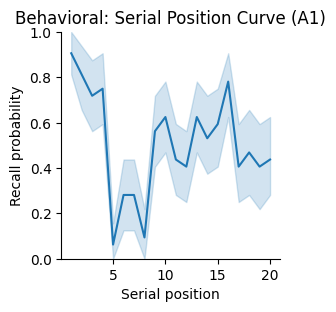

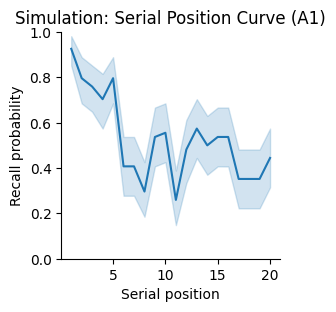

In [19]:
# %%capture
from psifr import fr
import matplotlib.pyplot as plt

# (1) Plot experimental data
df = pd.read_csv("data/psifr_al1_ml1_sl.csv")
df = df.query("modality == 'EEG' or modality == 'MRI'")
df = df.query("story_list == 'A' and passage == 1")

spc = fr.spc(df)
fr.plot_spc(df)
# plt.vlines(x=[5,10,15], ymin=0, ymax=1,colors="g", linestyles="dotted")
plt.title(f"Behavioral: Serial Position Curve (A1)")

# (2) Plot simulated data
spc = fr.spc(simulated_data)
fr.plot_spc(simulated_data)
plt.title(f"Simulation: Serial Position Curve (A1)")
# plt.vlines(x=[5,10,15], ymin=0, ymax=1,colors="g", linestyles="dotted")




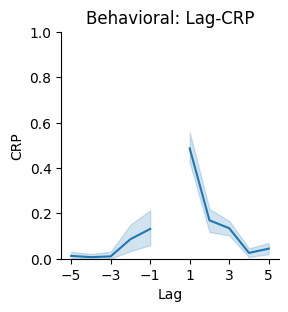

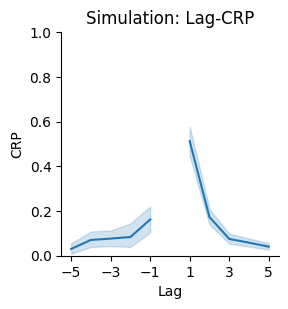

In [12]:
from psifr import fr

# (1) Plot experimental data
crp = fr.lag_crp(df)
fr.plot_lag_crp(crp)
plt.title("Behavioral: Lag-CRP")
plt.xticks(ticks=range(-5,6,2));

# (2) Plot simulated lag-crp
crp = fr.lag_crp(simulated_data)
fr.plot_lag_crp(crp)
plt.title("Simulation: Lag-CRP")
plt.xticks(ticks=range(-5,6,2));

###### **Network Plotting**

NameError: name 'net' is not defined

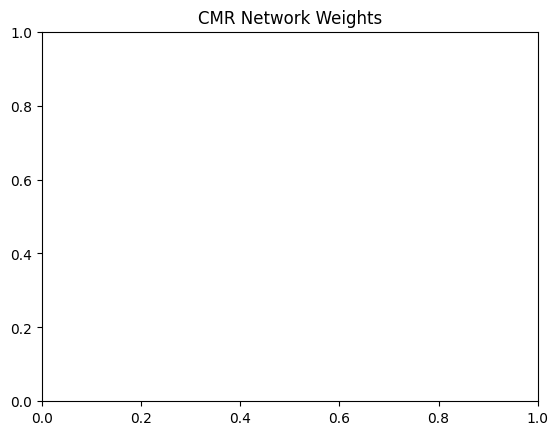

In [13]:
plt.title("CMR Network Weights");
feature_layer = net.f
context_layer = net.c
feature_to_context_weights = net.w_fc_exp
context_to_feature_weights = net.w_cf_exp
num_units = len(net.f)
units = [i for i in range(1,num_units+1)]
plt.yticks(ticks = units, labels=units[:-1] + ['start'])

for i in range(len(feature_layer)):
    plt.plot("F", i+1, "bo", alpha=feature_layer[i]+.1 if feature_layer[i]+.1  < 1 else 1 )
    plt.plot("C", i+1, "ro", alpha=context_layer[i]+.1 if context_layer[i]+.1 < 1 else 1 )

# Plot connections between units
for f_unit in units:
    for c_unit in units:
        importance = context_layer[c_unit-1] #feature_layer[f_unit-1]# *context_layer[c_unit-1]
        plt.plot(["F", "C"], [f_unit ,c_unit], "b-", alpha=importance*feature_to_context_weights[f_unit-1, c_unit-1]);
        plt.plot(["F", "C"], [f_unit ,c_unit], "r-", alpha=importance*context_to_feature_weights[c_unit-1, f_unit-1] if context_to_feature_weights[c_unit-1, f_unit-1]< 1 else 1 );
    

plt.title("During Retrieval: CMR Network Weights");

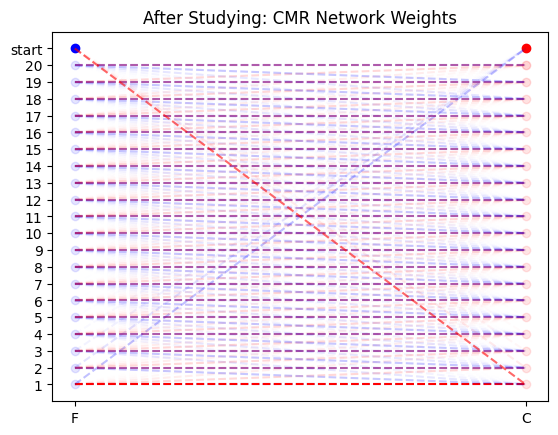

In [ ]:
feature_layer = net.f
context_layer = net.c
feature_to_context_weights = net.w_fc_exp
context_to_feature_weights = net.w_cf_exp
num_units = len(net.f)
units = [i for i in range(1,num_units+1)]
plt.yticks(ticks = units, labels=units[:-1] + ['start'])

for i in range(len(feature_layer)):
    plt.plot("F", i+1, "bo", alpha=feature_layer[i]+.1 if feature_layer[i]+.1  < 1 else 1 )
    plt.plot("C", i+1, "ro", alpha=context_layer[i]+.1 if context_layer[i]+.1 < 1 else 1 )

# Plot connections between units
for f_unit in units:
    for c_unit in units:
        plt.plot(["F", "C"], [f_unit ,c_unit], "b--", alpha=feature_to_context_weights[f_unit-1, c_unit-1]);
        plt.plot(["F", "C"], [f_unit ,c_unit], "r--", alpha=context_to_feature_weights[c_unit-1, f_unit-1] if context_to_feature_weights[c_unit-1, f_unit-1]< 1 else 1 );
    

plt.title("After Studying: CMR Network Weights");

# Additional Code

###### **(1) Manually Computing Stop Probabilities**
 We calculate the probability a participant rememebers nothing. This information will be used (as a parameter) in the networks.  (`No longer used`)
* We calculate a list of probabilities (`[p_0, p_1, ..., p_n]`), where `p_i` is the conditional probability that a participant will stop remembering stuff after recalling having recalled `i` sentences. This information will be used later to simulate free recalls.

In [ ]:
# # (0) Calculate the probability of not remembering anything
# our_data.head()
# groupby_columns = ["subject", "list"]
# num_empty_recalls = 0 
# for trial_index, trial in enumerate(our_data.groupby(groupby_columns)):
#     trial = trial[1]
#     if len(trial) ==  trial.trial_type.value_counts()["study"]:    # IF participant does not recall anything
#         num_empty_recalls += 1

# prob_no_recall = num_empty_recalls / trial_index
# print("prob_no_recall:", prob_no_recall)

# (1) Creates list of conditional prability of ending at each input position 
# input_endings = []
# groupby_columns= ["subject", "list"]
# for trial_index, trial in enumerate(our_data.groupby(groupby_columns)):
#     trial = trial[1]
#     input_ending = trial.query("trial_type == 'recall'").position.max()
#     input_endings.append(input_ending)

# num_trials = trial_index + 1
# num_trials
# # A participant can stop having remember 0 sentences (0) or after having rememeber 20 sentences
# endings_count = [input_endings.count(i) for i in range(21)]
# prob_of_ending = []
# for i in range(21):
#     if i == 0:
#         prob_of_ending.append(endings_count[0] / num_trials)
#     else:
#         trials_remaining = num_trials - sum(endings_count[:i-1])
#         if trials_remaining != 0:
#             prob_of_ending.append(endings_count[i]/trials_remaining)
#         else:
#             prob_of_ending.append(1)

# print(prob_of_ending)
# plt.figure(figsize=(6,2))
# plt.plot(prob_of_ending)
# plt.xticks(ticks = range(21));
# plt.xlabel("Output")
# plt.ylabel("CRP of Ending Recall");